In [27]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
import random
from matplotlib import style
from matplotlib.image import imread
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [28]:
# Paths
data_dir = 'GTSRB_dataset/traffic_Data'
train_path = 'GTSRB_dataset/traffic_Data/DATA'
test_path = 'GTSRB_dataset/traffic_Data/TEST'

# Resizing the images to 30x30x3
img_h = 32
img_w = 32
channels = 3

In [29]:
NUM_CATEGORIES = len(os.listdir(train_path))

# Number of classes
NUM_CATEGORIES

30

In [30]:
# How the labels look
classes = {
    0: 'Speed limit (5km/h)',
    1: 'Speed limit (15km/h)',
    2: 'Speed limit (30km/h)',
    3: 'Speed limit (40km/h)',
    4: 'Speed limit (50km/h)',
    5: 'Speed limit (60km/h)',
    6: 'Speed limit (70km/h)',
    7: 'speed limit (80km/h)',
    8: 'Dont Go straight or left',
    9: 'Dont Go straight or Right',
    10: 'Dont Go straight',
    11: 'Dont Go Left',
    12: 'Dont Go Left or Right',
    13: 'Dont Go Right',
    14: 'Dont overtake from Left',
    15: 'No Uturn',
    16: 'No Car',
    17: 'No horn',
    18: 'Speed limit (40km/h)',
    19: 'Speed limit (50km/h)',
    20: 'Go straight or right',
    21: 'Go straight',
    22: 'Go Left',
    23: 'Go Left or right',
    24: 'Go Right',
    25: 'keep Left',
    26: 'keep Right',
    27: 'Roundabout mandatory',
    28: 'watch out for cars',
    29: 'Horn'
}

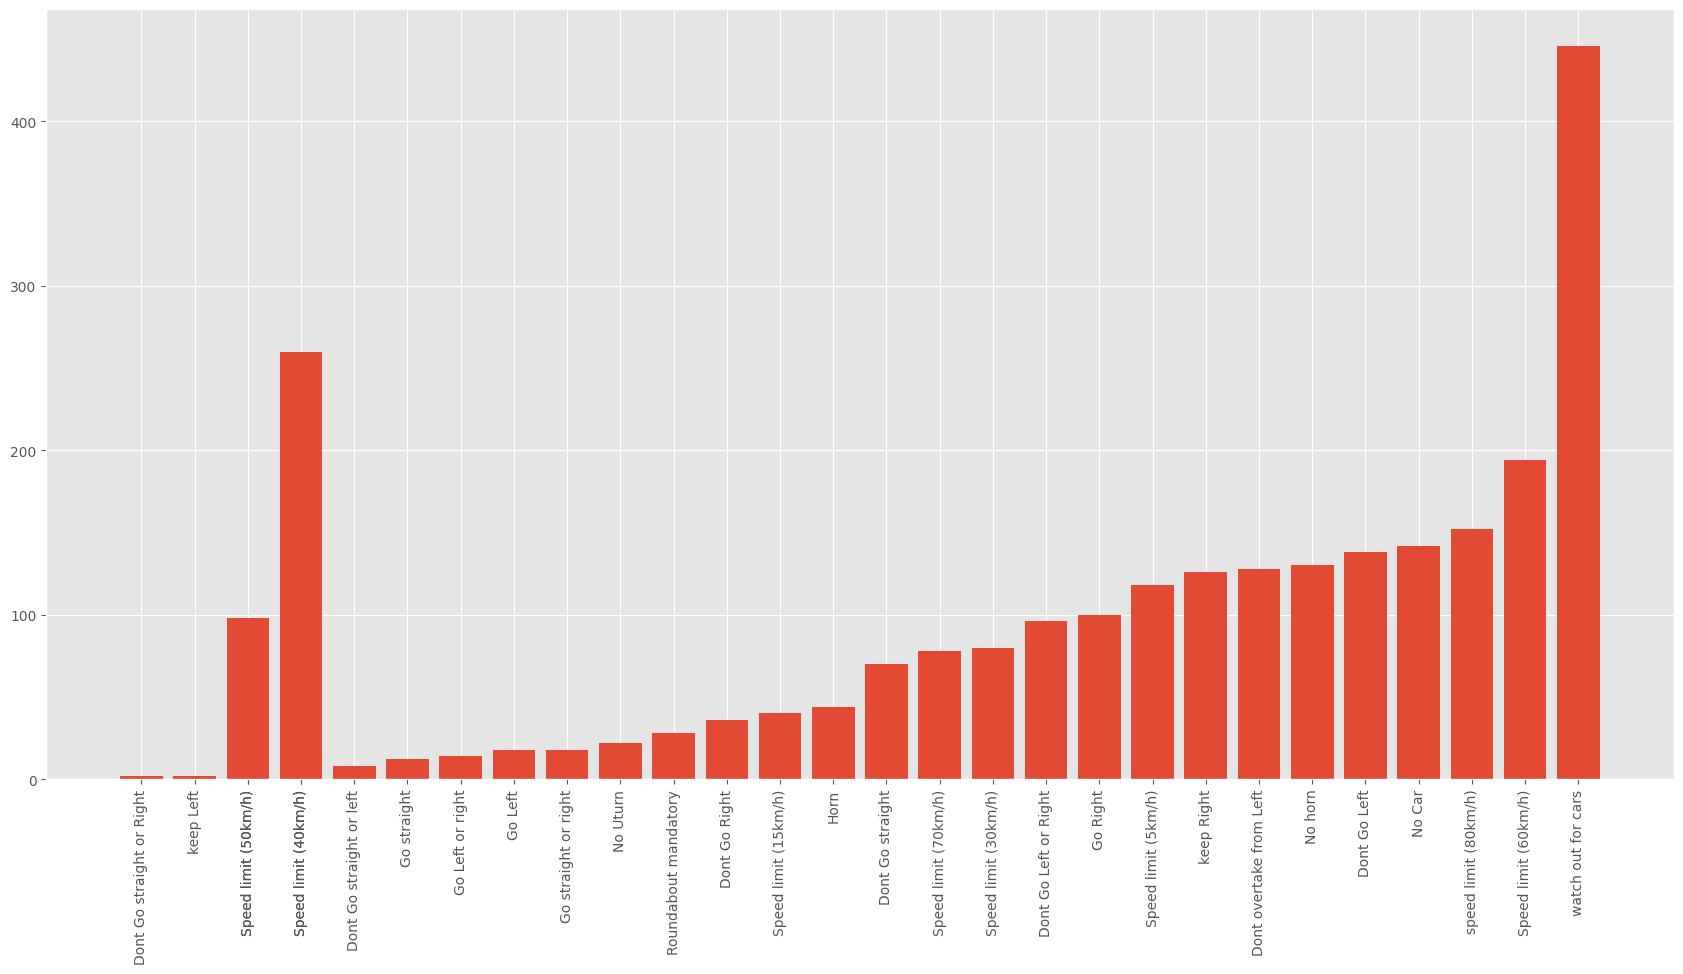

In [31]:

# Randomizer seed for consistency
np.random.seed(55)

# Visualization theme
plt.style.use('ggplot')

folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [32]:

# Directory for Test images
test_dir = './GTSRB_dataset/traffic_Data/TEST'

# Retrieve all images in test directory
image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Check the number of images
print(f"Number of test images: {len(image_paths)}")

Number of test images: 1200


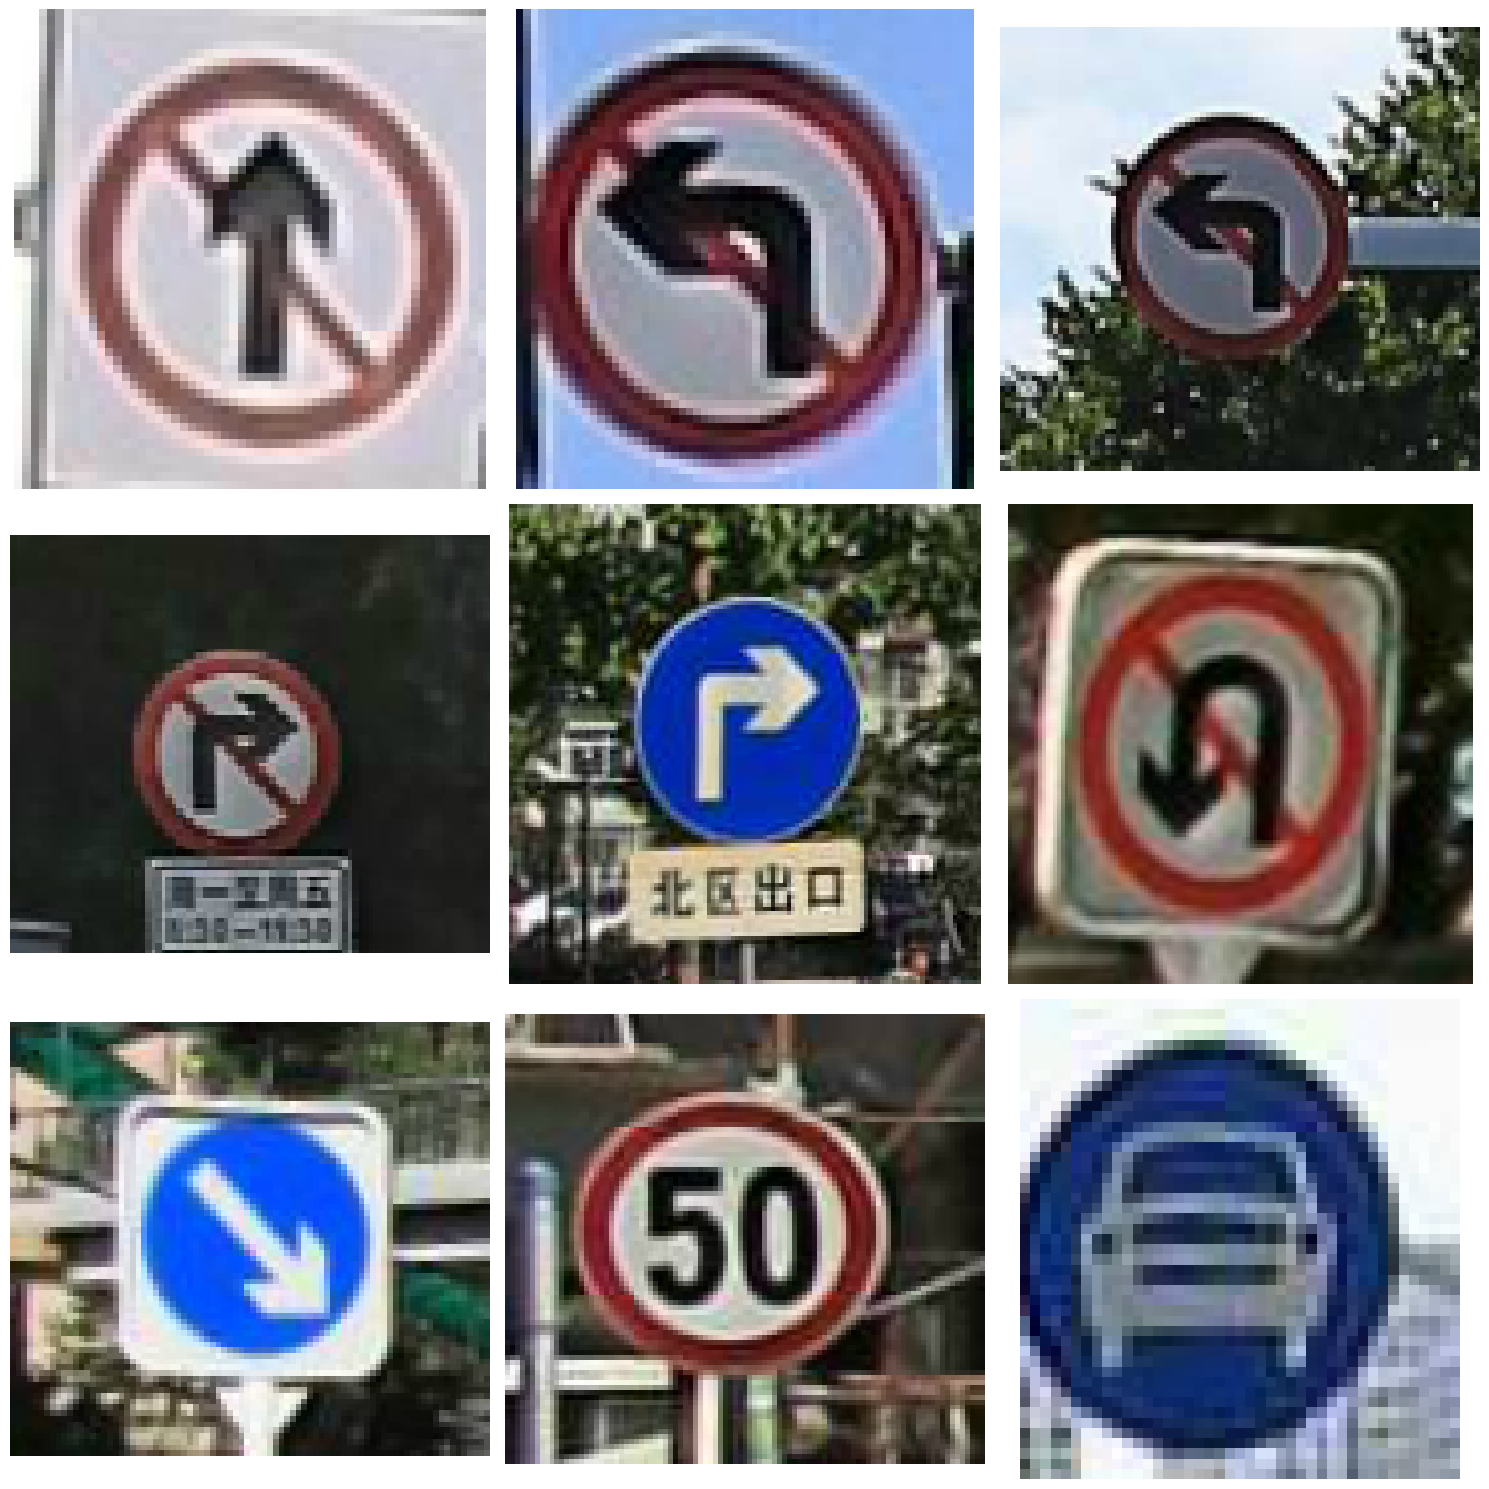

In [33]:
# Visualize random test images
plt.figure(figsize=(15, 15))

# 9 random images
for i in range(1, 10):
    plt.subplot(3, 3, i)
    random_img_path = random.choice(image_paths)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
# List where pixel data will be stored
image_data = []

# List where labels of images are stored
image_labels = []

# Iterates through classes and retrieves list of images file names
for i in range(NUM_CATEGORIES):
    path = data_dir + '/DATA/' + str(i)
    images = os.listdir(path)

    # Each image is read and processed
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)

            # Converts NumPy array image into PIL image in RGB format
            image_fromarray = Image.fromarray(image, 'RGB')

            # Resizes image to 32x32
            resize_image = image_fromarray.resize((img_h, img_w))

            # converts image back to NumPy array and appends it to "image_data" list
            image_data.append(np.array(resize_image))

            # Appends labels to the "image_labels" list to keep track of image order
            image_labels.append(i)
        except:
            print("Error for " + img)

# Converts lists into NumPy arrays
image_data = np.array(image_data)
image_labels = np.array(image_labels)

# Shows number of images, dimensions, and Labels corresponding to them
print(image_data.shape, image_labels.shape)

(2607, 32, 32, 3) (2607,)


In [35]:
# Creats ordered array of image indexes 0 - 4170
shuffle_indexes = np.arange(image_data.shape[0])

# Shuffles image indexes 0 - 4170
np.random.shuffle(shuffle_indexes)

# Re orders images
image_data = image_data[shuffle_indexes]

# Re orders labels to ensure proper alignment with images
image_labels = image_labels[shuffle_indexes]

In [36]:
# Splits the data into a training set and a validation set. 30% of data used for validation, 70% used for training. 
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

# Normalizes pixel values to (0 to 1) for training and validation sets
X_train = X_train/255 
X_val = X_val/255

# Prints the ratio. X represents data, Y represents labels
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (1824, 32, 32, 3)
X_valid.shape (783, 32, 32, 3)
y_train.shape (1824,)
y_valid.shape (783,)


In [37]:
# Converts training labels to one-hot encoded vectors
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)

# Converts validation lebels to one-hot encoded vectors
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

# Prints shape of one-hot encoded labels
print(y_train.shape)
print(y_val.shape)

(1824, 30)
(783, 30)


In [ ]:
# CNN Architecture and Layers

# Sequential Model
model = keras.models.Sequential([    

    # Input Layer. Extracts low level features such as edges adn textures. 
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(img_h, img_w,channels)),
    
    # First convolutional block
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    # Second convolutional block
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    # Flatten layer
    keras.layers.Flatten(),

    # Fully connected layers
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.50),
    
    # Output layer. Converts outputs into probabilities with softmax
    keras.layers.Dense(30, activation='softmax')
])

c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Learning Rate
lr = 0.001

# Number of epochs
epochs = 30

# Define the optimizer "Adam"
opt = Adam(learning_rate=lr)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [40]:
# Saves the best trained model
callbacks = [
    ModelCheckpoint('trained_CNN.keras', save_best_only=True, monitor='val_loss')
]

In [41]:
# Increasing model diversity in training data. Prevents overfitting.

# applies real time data augmentation to images. Improves generalization and helps prevent overfitting
aug = ImageDataGenerator(

    # Randomly rotates images from 0 - 10 degrees
    rotation_range=10,

    # Randomly zooms into image up to 15%
    zoom_range=0.15,

    # Randomly shifts image horizontally up to 10%
    width_shift_range=0.1,

    # Randomly shifts image vertically up to 10%
    height_shift_range=0.1,

    # Randomly shears image up to 15%
    shear_range=0.15,

    # Disables image flipping as traffic signs are read in the upright position. 
    horizontal_flip=False,
    vertical_flip=False,

    # Gaps in the image will be filled with values from the nearest pixel
    fill_mode="nearest"
    )

In [42]:
# Trains the Model
history = model.fit(

    # Generates augmented images
    aug.flow(X_train, y_train,batch_size=32),

    # Defines number of epochs, in our case 30
    epochs=epochs,
    
    # Validation set used to monitor models performance
    validation_data=(X_val, y_val),

    # calls to create best trained model "best_model.keras"
    callbacks=callbacks
    )

Epoch 1/30


c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.3802 - loss: 2.8059 - val_accuracy: 0.1009 - val_loss: 3.1825
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7635 - loss: 0.8283 - val_accuracy: 0.0639 - val_loss: 3.4390
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8691 - loss: 0.4206 - val_accuracy: 0.0204 - val_loss: 4.2314
Epoch 4/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8988 - loss: 0.3160 - val_accuracy: 0.0677 - val_loss: 5.3513
Epoch 5/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9150 - loss: 0.2450 - val_accuracy: 0.0868 - val_loss: 4.9706
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.9375 - loss: 0.1856 - val_accuracy: 0.1992 - val_loss: 3.8769
Epoch 7/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9604 - loss: 0.1225 - val_accuracy: 0.2937 - val_loss: 3.4837
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9726 - loss: 0.0936 - val_accuracy: 0.4610 - val_loss: 1.

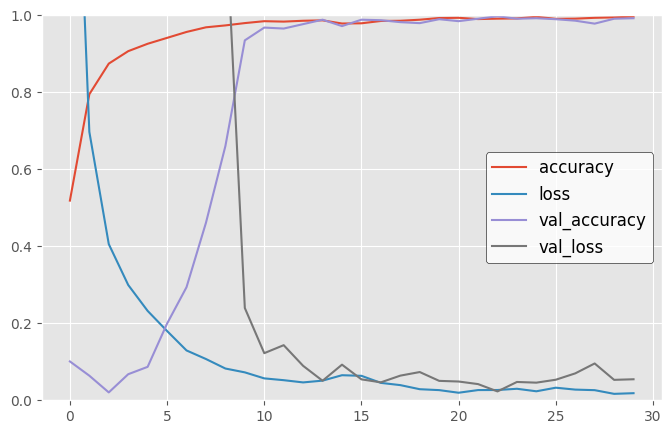

In [43]:
# Turns model history into Pandas Dataframe
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend(facecolor='white', edgecolor='black', fontsize=12, loc='best', frameon=True, labelcolor='black')

# Show dataframe
plt.show()

In [44]:
# Define the test directory
test_dir = './GTSRB_dataset/traffic_Data/TEST'

# Retrieve all test image paths
image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir)if f.endswith(('.png', '.jpg', '.jpeg'))]

# Extracts test labels
labels = []
for path in image_paths:
    try:
        # Extract the file name
        file_name = os.path.basename(path)
        
        # Extract file name label
        label = int(file_name.split('_')[0])
        labels.append(label)
    except Exception as e:
        print(f"Error processing the file {path}: {e}")

# Load and preprocess test images
data = []
for img_path in image_paths:
    try:
        # Reads image
        image = cv2.imread(img_path)

        # Converts image into PIL RGB format
        image_fromarray = Image.fromarray(image, 'RGB')

        # Resizes image to 32x32
        resize_image = image_fromarray.resize((img_h, img_w))

        # Converts image back to NumPy array
        data.append(np.array(resize_image))

    except Exception as e:
        print(f"Error for {img_path}: {e}")

# Converts pixel values to range (0 to 1)
X_test = np.array(data) / 255.0

# Predicts probabilities using the trained model images in each class
pred = model.predict(X_test)

# Creates labels
pred_classes = np.argmax(pred, axis=1)

# Calculate Test Data Accuracy Percentage
print('Test Data Accuracy:', accuracy_score(labels, pred_classes) * 100)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Data Accuracy: 80.58333333333333


In [45]:
# Ensure predictions are class indices
if pred.ndim > 1:
    pred = np.argmax(pred, axis=1)

# Ensure labels are class indices
if isinstance(labels, list) or isinstance(labels, np.ndarray):
    labels = np.array(labels)  # Ensure labels are a NumPy array
if labels.ndim > 1:  # If labels are one-hot encoded
    labels = np.argmax(labels, axis=1)

# Verify compatibility
print(f"Labels shape: {labels.shape}, Predictions shape: {pred.shape}")
print("---")
print(f"Unique labels: {np.unique(labels)}")
print("---")
print(f"Unique predictions: {np.unique(pred)}")


Labels shape: (1200,), Predictions shape: (1200,)
---
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
---
Unique predictions: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


In [46]:
# Classification Report. Precision, Recall, F1-Score and Support
print(classification_report(labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.56      0.83      0.67        12
           2       0.90      0.87      0.88        60
           3       0.97      0.86      0.91        84
           4       0.55      0.93      0.69        58
           5       0.81      0.68      0.74        50
           6       0.67      0.93      0.78        30
           7       0.57      0.24      0.34        50
           8       1.00      1.00      1.00        14
           9       0.00      0.00      0.00         1
          10       0.97      0.97      0.97        60
          11       1.00      0.98      0.99       130
          12       0.61      1.00      0.76        22
          13       1.00      0.63      0.77        92
          14       0.71      0.83      0.77        12
          15       1.00      0.44      0.62        36
          16       0.57      0.95      0.71        76
          17       1.00    

c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alons\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

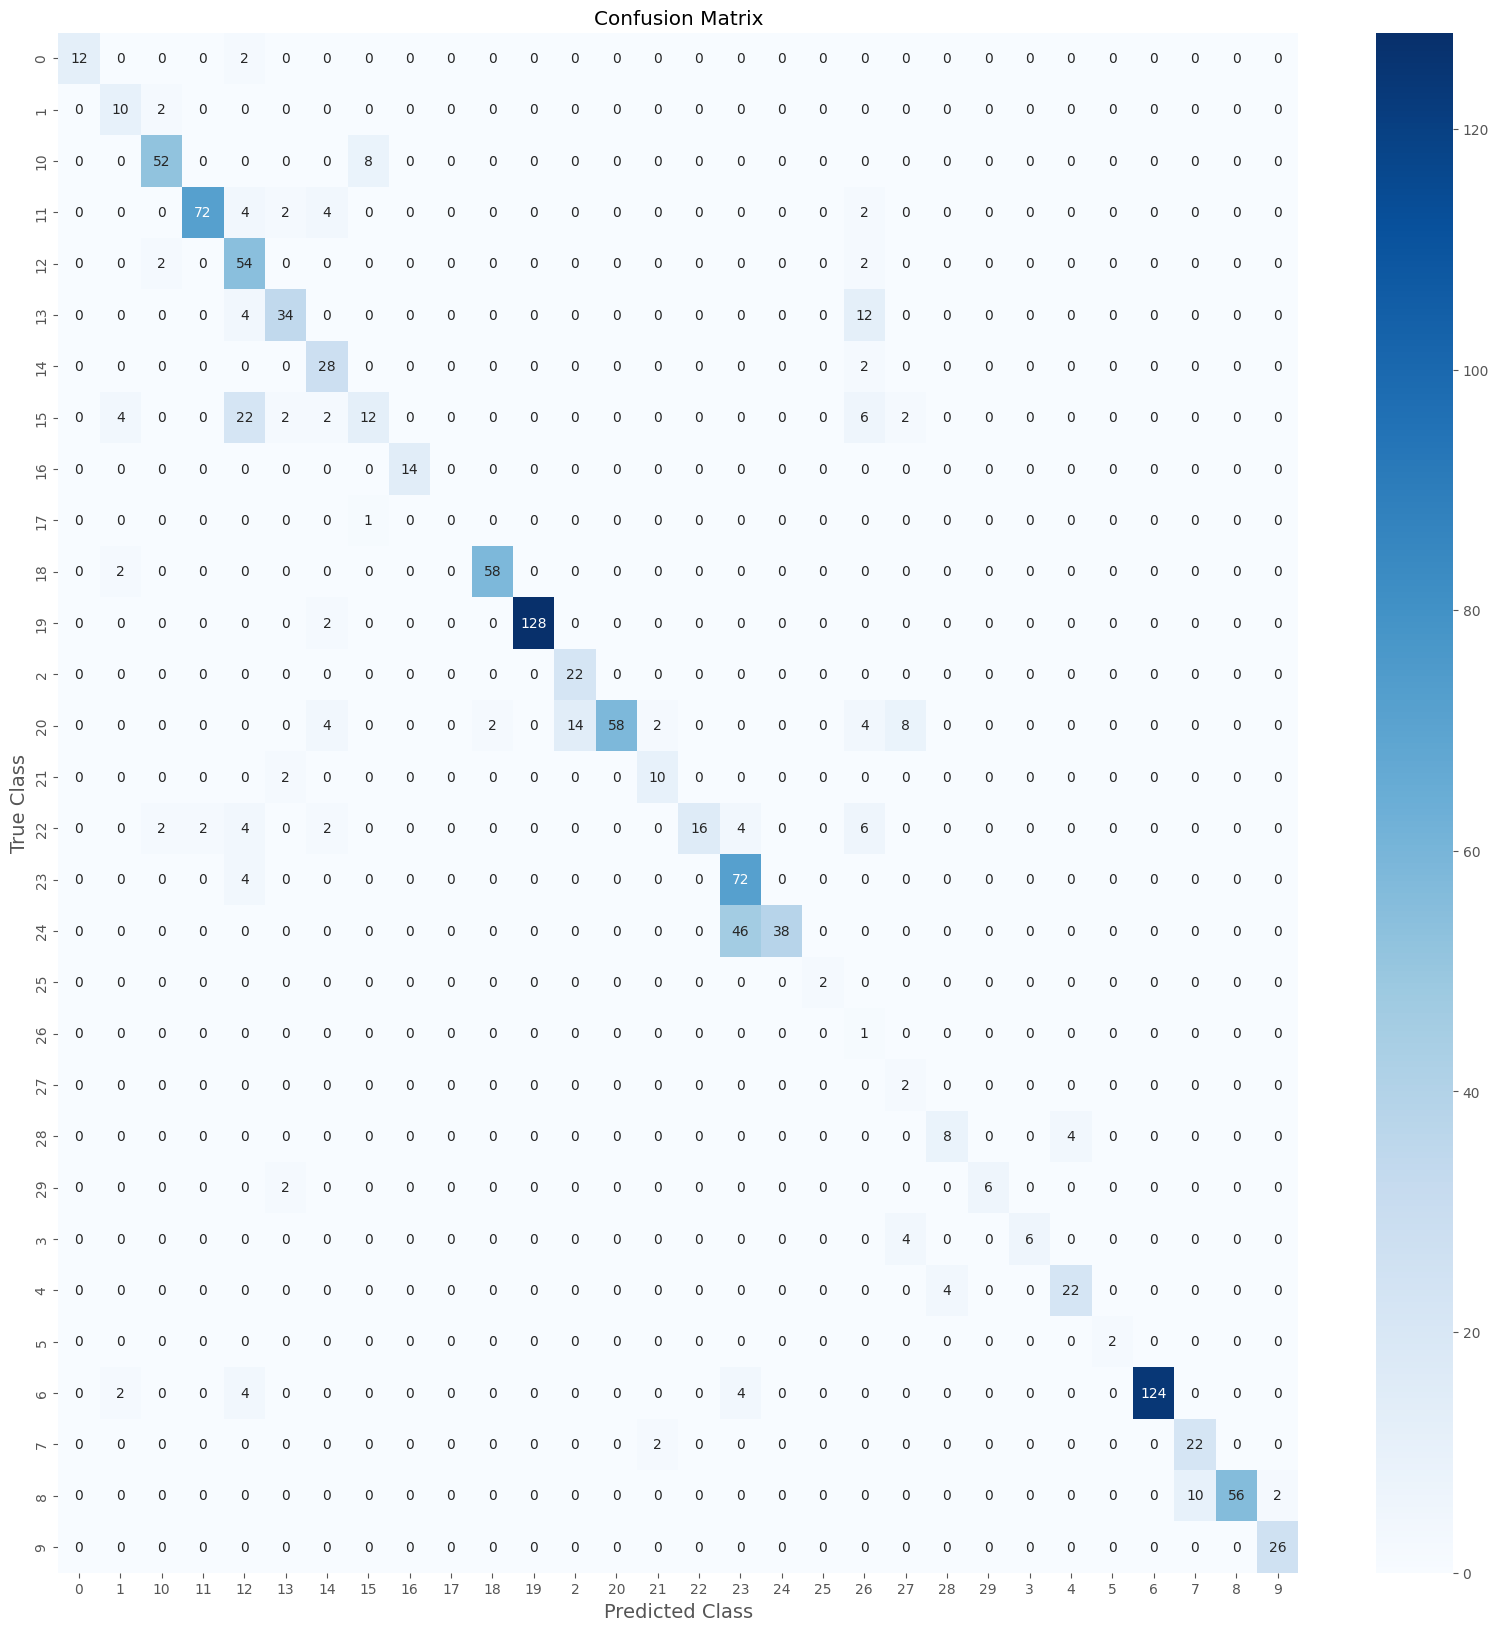

In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to the labeled data directory
data_dir = './GTSRB_dataset/traffic_Data/DATA'

# Extract class names from folder names
classes = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
classes.sort()  # Ensure the classes are sorted numerically

# Extract test labels from the file names in image_paths
labels = []
for path in image_paths:  # Ensure `image_paths` contains paths to all test images
    try:
        # Extract the file name
        file_name = os.path.basename(path)
        
        # Extract the label from the file name (assumes the format "057_0002_j.png")
        label = int(file_name.split('_')[0])  # Extract the first segment as the label
        labels.append(label)
    except Exception as e:
        print(f"Error processing the file {path}: {e}")

# Ensure predictions (`pred`) are numeric class indices
if pred.ndim > 1:  # If predictions are probabilities, convert to class indices
    pred = np.argmax(pred, axis=1)

# Validate that labels and predictions match
labels = np.array(labels)
if len(labels) != len(pred):
    print(f"Error: Number of labels ({len(labels)}) does not match number of predictions ({len(pred)}).")
    raise ValueError("Mismatch between labels and predictions.")

# Generate confusion matrix
cf = confusion_matrix(labels, pred, labels=range(len(classes)))

# Create a confusion matrix DataFrame
df_cm = pd.DataFrame(cf, index=classes, columns=classes)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.show()


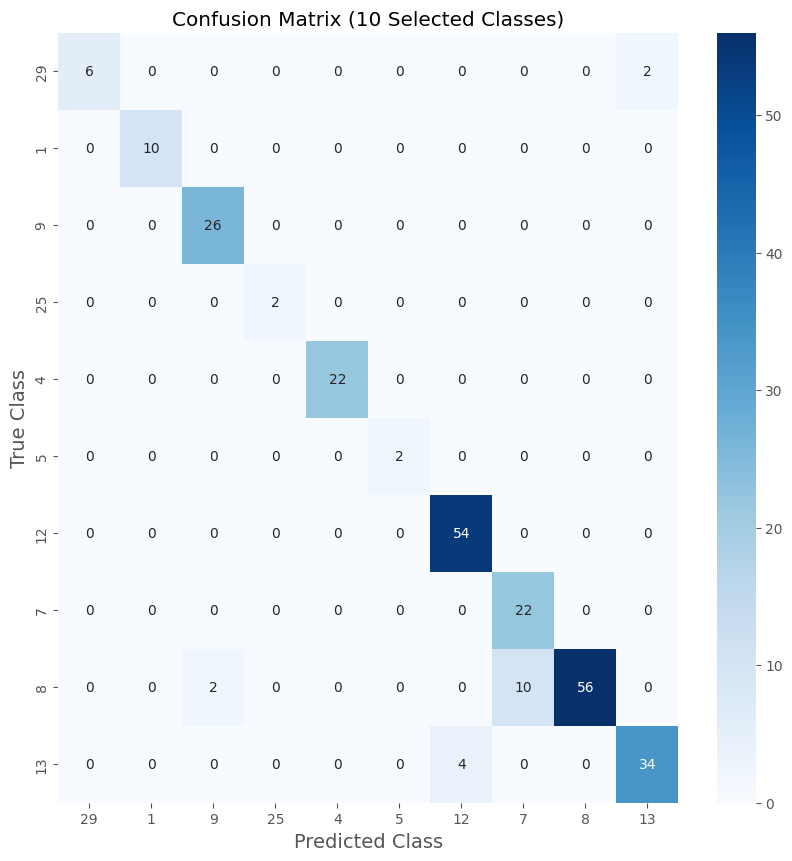

In [56]:
# Confusion Matrix for 10 random classes

# Define your specific 10 classes (must match actual class names in `classes`)
selected_classes = ['29', '1', '9', '25', '4', '5', '12', '7', '8', '13']  # Replace with desired classes

# Ensure the selected classes exist in `classes`
selected_indices = [classes.index(cls) for cls in selected_classes]
filtered_cf = cf[np.ix_(selected_indices, selected_indices)]

# Create a filtered DataFrame
df_filtered_cm = pd.DataFrame(filtered_cf, index=selected_classes, columns=selected_classes)

# Plot the filtered confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(df_filtered_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (10 Selected Classes)")
plt.xlabel("Predicted Class", fontsize=14)
plt.ylabel("True Class", fontsize=14)
plt.show()


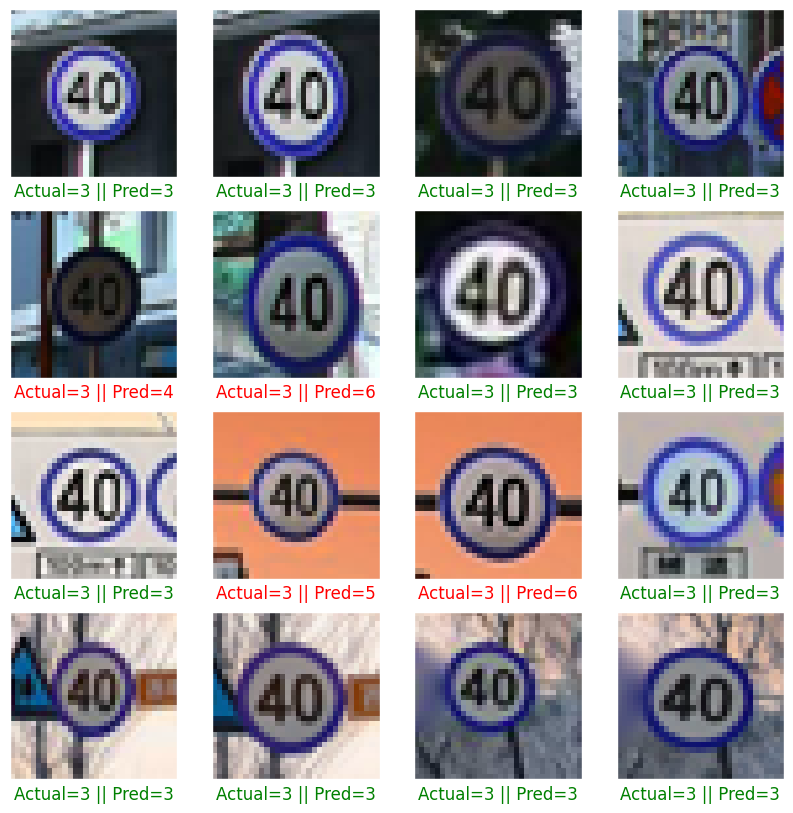

In [57]:
plt.figure(figsize = (10, 10))

# Test image index
start_index = 100

# Iterates 16 images
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Retrieves Predictions
    prediction = pred[start_index + i]

    # Retrieves actual labels
    actual = labels[start_index + i]

    # Green for correct, red for incorrect
    col = 'g'
    if prediction != actual:
        col = 'r'

    # Displays labels
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)

    # Displays image
    plt.imshow(X_test[start_index + i])

plt.show()

In [58]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,260,604 (20.07 MB)

 Trainable params: 1,753,086 (6.69 MB)

 Non-trainable params: 1,344 (5.25 KB)

 Optimizer params: 3,506,174 (13.37 MB)